# Basic scVI Tutorial

In [8]:
import os
os.chdir("/Users/zx3/PycharmProjects/scVI/tests")


In [20]:
%matplotlib inline

### Loading Config

In [2]:
n_epochs_all = None
save_path = 'data/' 
show_plot = True

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, RetinaDataset
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
import torch

In [4]:
x=2+2
z=2-10
import sys
import os
print(os.getcwd())
print(sys.version)
print(x-z)

/Users/zx3/PycharmProjects/scVI/tests/notebooks
3.7.2 (v3.7.2:9a3ffc0492, Dec 24 2018, 02:44:43) 
[Clang 6.0 (clang-600.0.57)]
12


## Loading data

Here we load the CORTEX dataset described in

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

Please see our data loading Jupyter notebook for more examples of data loading -- scVI has many "built-in" datasets, as well as support for loading arbitrary .csv, .loom, and .h5ad (AnnData) files.

In [5]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
gene_dataset = CortexDataset(save_path=save_path)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


## Training

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA. 


In [10]:
n_epochs=400 if n_epochs_all is None else n_epochs_all
lr=1e-3
use_batches=False
use_cuda=True

**Train the model and output model likelihood every 5 epochs**
**If a pre-trained model already exist in the save_path then load the same model rather than re-training it** 

In [11]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              gene_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)

    

In [14]:
if os.path.isfile('%s/vae.pkl' % save_path ):
    trainer.model.load_state_dict(torch.load('%s/vae.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/vae.pkl' % save_path)

In [17]:
trainer.train(n_epochs=n_epochs, lr=lr)
torch.save(trainer.model.state_dict(), '%s/vae.pkl' % save_path)

training: 100%|██████████| 400/400 [03:40<00:00,  1.62it/s]


** Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

(1000, 2000)

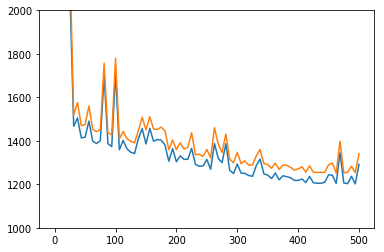

In [22]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(1000,2000)


## Obtaining the posterior object and sample latent space from it

The posterior object contains a model and a gene_dataset, as well as additional arguments that for Pytorch's `DataLoader`. It also comes with many methods or utilities querying the model, such as differential expression, imputation and differential analyisis.


To get an ordered output result, we might use `.sequential` posterior's method which return another instance of posterior (with shallow copy of all its object references), but where the iteration is in the same ordered as its  indices attribute.



In [23]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

## Visualizing the latent space

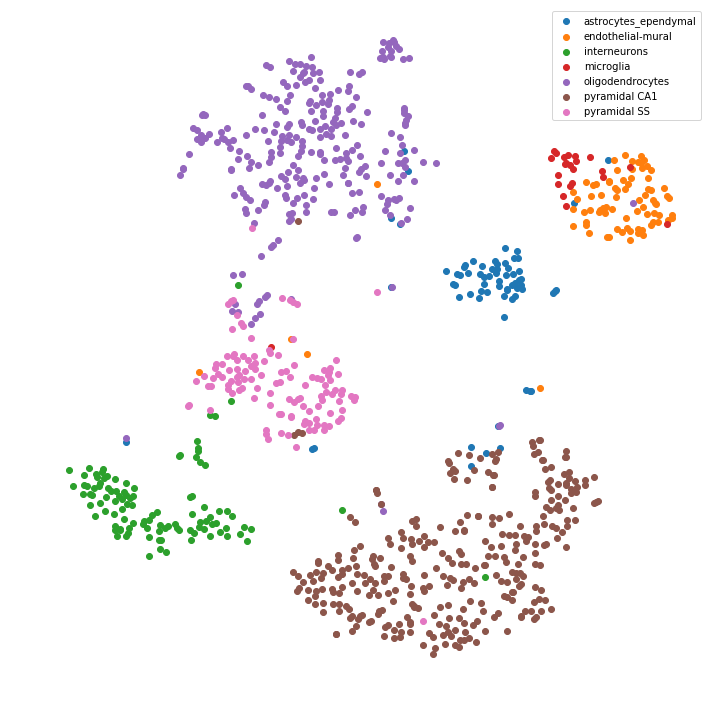

In [24]:
n_samples_tsne = 1000
full.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

## Imputation


The ability to impute missing values is useful in practical applications in addition to providing an assay for generalization performance. In the following analysis, we benchmark scVI against BISCUIT, ZINB-WaVE and ZIFA, as well as MAGIC, which provides imputation without explicit statistical modeling. To evaluate these methods on a given dataset, we generated a **corrupted training set**, and then fitted the perturbed dataset with each of the benchmark methods and evaluate them by comparing the imputed values to the original ones (Methods 4.7). Overall, we observe that the imputation accuracy of scVI is higher or comparable (less than one transcript for median error) across all datasets

#### Corrupting the datasets for imputation benchmarking. 

Two different approaches to measure the robustness of algorithms to noise in the data: 

- **Uniform zero introduction**: select randomly a rate r% of the non-zero entries and multiply the entry n with a Ber(0.9) random variable.
- **Binomial data corruption**: select a rate r% of the matrix and replace an entry n by a Bin(n, 0.2) random variable.

By default, the rate r is set a 0.1

#### Accuracy of imputing missing data 

As imputation tantamount to replace missing data by its mean conditioned on being observed, we use the median L1 distance between the original dataset and the imputed values for corrupted entries only.
Parameters:
* The rate of simulated dropout is defined by __rate__, here set ot 0.1 

training: 100%|██████████| 400/400 [03:22<00:00,  2.10it/s]

Median of Median: 2.2070
Mean of Median for each cell: 3.1363


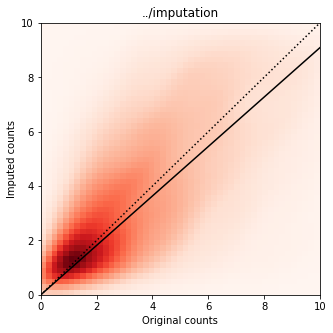

<Figure size 432x288 with 0 Axes>

In [25]:
n_epochs = 400 if n_epochs_all is None else n_epochs_all
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              gene_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda)

trainer.corrupt_posteriors(rate=0.1, corruption="uniform")
trainer.train(n_epochs)
trainer.uncorrupt_posteriors()

original_list, imputed_list = trainer.train_set.imputation_benchmark(verbose=True, n_samples=1, 
                                                                     show_plot=show_plot, save_path='../')

In [26]:
# Median of medians for all distances
imputation_errors = np.abs(np.concatenate(original_list) - np.concatenate(imputed_list))
median_imputation_score = np.median(imputation_errors)
print(median_imputation_score)

2.2069576


We then plot the distribution of absolute errors between the imputed value and the true value at the dropout positions. 

Note: The imputed value __px_rate__ is the rate parameter (expected value) of the Zero-Inflated Negative Binomial (ZINB) distribution.

(array([  10.,   48.,  211.,  932., 3204., 3590.,  786.,   72.,   15.,
           6.]),
 array([-2.89992309, -2.25223854, -1.60455399, -0.95686944, -0.30918489,
         0.33849967,  0.98618422,  1.63386877,  2.28155332,  2.92923787,
         3.57692242]),
 <a list of 10 Patch objects>)

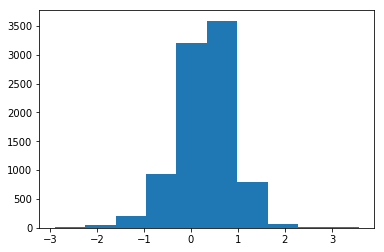

In [27]:
plt.hist(np.log10(imputation_errors))

## Obtaining the imputed values for the whole dataset after the training

### Imputing without artificial corruption

Through the imputation benchmark above, we have assessed the strength of scVI for this task. 

To actually perform the imputation on a model trained on regular data, we might use the `.imputation` method. 

In [24]:
imputed_values = full.sequential().imputation()

[[ 53.47371     2.7984838  65.87689   ...   2.2331746  23.029055
    1.1846611]
 [ 84.330414    4.0699735  94.733154  ...   3.493925   32.392834
    1.8417363]
 [420.23178    64.7878    415.2183    ...  69.8366    223.3588
   39.901802 ]
 ...
 [ 84.602356    4.039021  108.5918    ...   4.1821527  38.763287
    1.7649246]
 [113.8011     10.139282  121.34298   ...  10.602282   50.404457
    5.1777377]
 [136.09386    15.520703  160.3098    ...  15.985491   72.87104
    9.781753 ]]


## Differential Expression
From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by __logit(p/(1-p))__ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

**1. Set population A and population B for comparison**

In [25]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



**2. Define parameters**
* __n_samples__: the number of times to sample __px_scales__ from the vae model for each gene in each cell.
* __M_permutation__: Number of pairs sampled from the px_scales values for comparison.

In [39]:
n_samples = 100
M_permutation = 100000

In [44]:
de_res = full.differential_expression_score(cell_idx1, cell_idx2, n_samples=n_samples, 
                                   M_permutation=M_permutation)

**3. Print out the differential expression value**
* bayes1: The bayes factor for cell type 1 having a higher expression than cell type 2
* bayes2: The bayes factor for cell type 2 having a higher expression than cell type 1 (should be ~ -bayes1, but not equal due to ties in comparing per cell expression, and stochasticity of sampling. 
* bayes*i*_permuted: the bayes factor when cell types labels are premuted 
* mean*i*: average UMI counts in cell type *i*
* nonz*i*: proportion of non-zero expression in cell type *i*
* norm_mean*i*: average UMI counts in cell type *i* normalized by cell size
* scale*i*: average scVI imputed gene expression scale in cell type *i* 


In [49]:
genes_of_interest = ["THY1", "MBP"]
de_res.filter(items=genes_of_interest,axis=0)

,bayes1,bayes1_permuted,bayes2,bayes2_permuted,mean1,mean2,nonz1,nonz2,norm_mean1,norm_mean2,scale1,scale2
THY1,-0.084610,0.01620,0.085212,0.01196,8.777778,8.666667,1.0,1.0,1.050747,1.022995,0.009576,0.010692
MBP,-0.029722,0.01616,0.040245,0.00564,8.777778,8.666667,1.0,1.0,1.043780,1.022995,0.000718,0.000952


**4. Plot the null distribution of the DE values**

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  4., 29., 19.]),
 array([-0.00416001, -0.00180794,  0.00054412,  0.00289618,  0.00524824,
         0.0076003 ,  0.00995236,  0.01230442,  0.01465648,  0.01700854,
         0.0193606 ]),
 <a list of 10 Patch objects>)

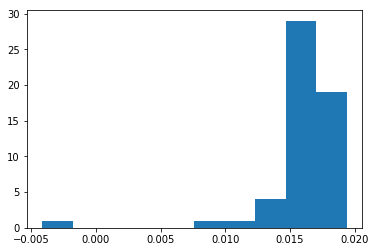

In [50]:
plt.hist(de_res['bayes1_permuted'])

**9. Visualize top 10 most expressed genes per cell types**

In [28]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

In [29]:
markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

In [30]:
genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['norm_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

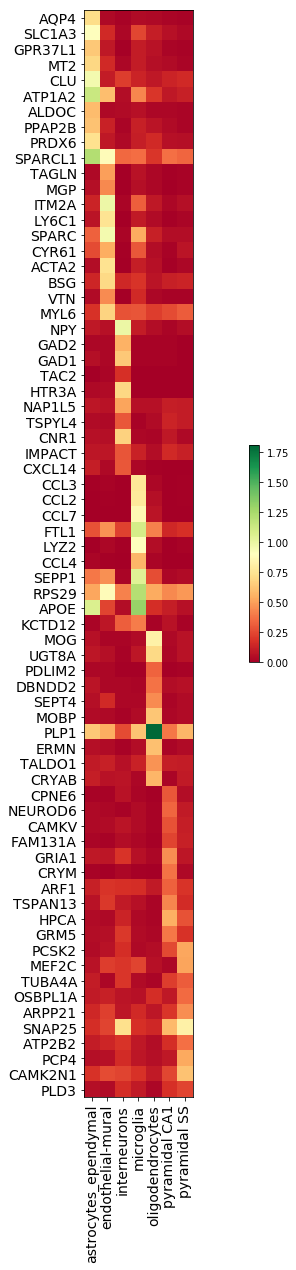

In [31]:
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='RdYlGn', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)

## Correction for batch effects

First we load the RETINA dataset that is described in

* Shekhar, Karthik, et al. "Comprehensive classification of retinal bipolar neurons by single-cell transcriptomics." Cell 166.5 (2016): 1308-1323.

In [32]:
gene_dataset = RetinaDataset(save_path=save_path)

Preprocessing dataset
Finished preprocessing dataset


In [33]:
n_epochs=50 if n_epochs_all is None else n_epochs_all
lr=1e-3
use_batches=True
use_cuda=True

### Train the model and output model likelihood every 5 epochs
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae, 
                              gene_dataset, 
                              train_size=0.9, 
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training:   8%|▊         | 4/50 [04:15<48:57, 63.85s/it]


KeyboardInterrupt: 

(539.8292791193181, 1000)

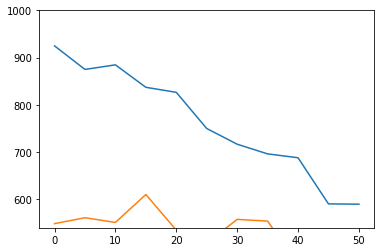

In [59]:
# Plotting the likelihood change across the 50 epochs of training: blue for training error and orange for testing error. 

ll_train = trainer.history["ll_train_set"]
ll_test = trainer.history["ll_test_set"]
x = np.linspace(0,50,(len(ll_train)))
plt.plot(x, ll_train)
plt.plot(x, ll_test)
plt.ylim(min(ll_train)-50, 1000)

**Computing batch mixing**

In [60]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
print("Entropy batch mixing :", full.entropy_batch_mixing())

Entropy batch mixing : 0.6719543765630727


**Coloring by batch and cell type**

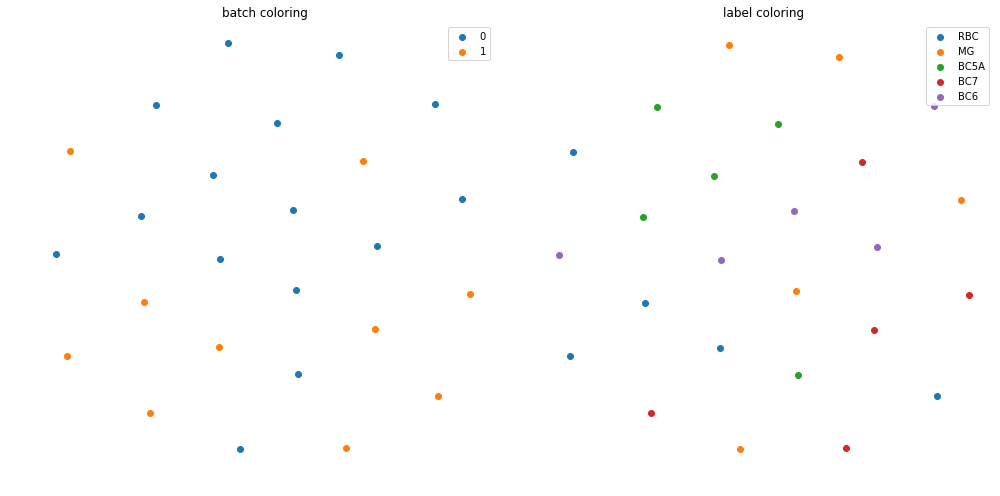

In [61]:
# obtaining latent space in the same order as the input data
n_samples_tsne = 1000
full.show_t_sne(n_samples=n_samples_tsne, color_by='batches and labels')

In [62]:
def allow_notebook_for_test():
    print("Testing the basic tutorial notebook")